# Real time evolution in the source and gate well

In [16]:
import math
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from scipy import fftpack

# Loading the ground state in the source well

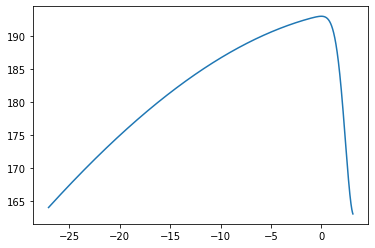

In [17]:
ground_state_position,initial_ground_state_wavefunction= np.loadtxt("ground_state_wavefunction_source_well.txt", delimiter = '\t', unpack=True)
plt.plot(ground_state_position/(1.e-6),initial_ground_state_wavefunction)
plt.show()

In [18]:
source_well_length = len(ground_state_position)

# Extracting the source and gate well

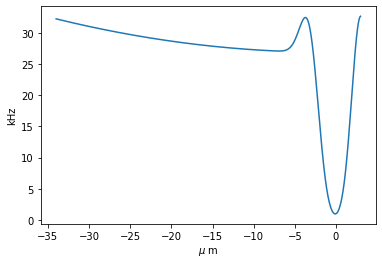

In [19]:
position_landscape,potential_landscape= np.loadtxt("potential_landscape.txt", delimiter = '\t', unpack=True)
def extract_source_and_gate_well_potential(position,potential):
    
    # Position where the gate well starts.
    gate_well_start_index = -34
    # Position where the gate well ends.
    gate_well_end_index   = 2.98
    # Extracts the gate well position.
    well_position = position[np.where((position > gate_well_start_index) & (position < gate_well_end_index))]
    # Extract the corresponding potential values for the gate well.
    well_potential = potential[np.where(position == well_position[0])[0][0]:np.where(position == well_position[-1])[0][0]+1]
    
    return [well_position,well_potential]

source_and_gate_well_position  = extract_source_and_gate_well_potential(position_landscape,potential_landscape)[0]
source_and_gate_well_potential = extract_source_and_gate_well_potential(position_landscape,potential_landscape)[1]
plt.plot(source_and_gate_well_position,source_and_gate_well_potential)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

In [20]:
source_gate_well_length = len(source_and_gate_well_position)

# Shifting the minimum of the potential to position zero

Minimum of the gate well, =  0.0 , location, =  0.0


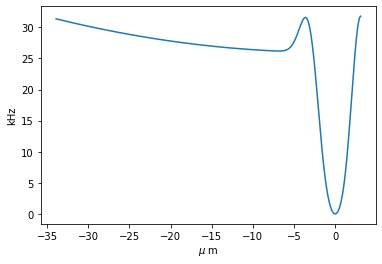

In [21]:
source_and_gate_well_potential_min_index = [np.where(source_and_gate_well_potential == min(source_and_gate_well_potential))][0][0][0]
source_and_gate_well_potential = source_and_gate_well_potential - min(source_and_gate_well_potential)
source_and_gate_well_position = source_and_gate_well_position-source_and_gate_well_position[source_and_gate_well_potential_min_index]
# Prints the new location of the potential minima and its value.
print("Minimum of the gate well, = ", min(source_and_gate_well_potential), ", location, = ",
      source_and_gate_well_position[[np.where(source_and_gate_well_potential == min(source_and_gate_well_potential))][0][0][0]])
plt.plot(source_and_gate_well_position,source_and_gate_well_potential)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

# Parameters and the Hamiltonian

In [22]:
"""
The potential is in kHz units. It is converted to SI units
by multiplying 10^3 * h.
"""
PI = np.pi
H_BAR = 6.626*10**(-34)/(2*PI)
xs = source_and_gate_well_position
external_potential = source_and_gate_well_potential
N  = len(external_potential)
r""" Rb87 parameters """
# Mass of Rb87 atom.
M   = 1.4192261*10**(-25) # kg
# s wave scattering length of Rb87 atom.
a_s = 98.006*5.29*10**(-11) # m https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.053614
# trapping frequency in the source and gate well.
trap_frequency = 2*PI*850 # Hz
trap_length = np.sqrt(H_BAR/(M*trap_frequency)) # m
A = PI*trap_length**2
# Number of atoms in the source well.
N_atom = 20*10**3
g   = (4*PI*H_BAR**2*a_s)/(A*M)


# Length of the space interval.
L  = len(xs)#(max(xs)-min(xs))
# Increment in the space interval.
dx = np.abs(xs[1]-xs[0])
# Increment in momentum space interval.
dk = (2*PI)/L

external_potential = source_and_gate_well_potential*(10**3)*2*PI*(H_BAR) # J
xs = source_and_gate_well_position*1.e-6 # m

N  = len(external_potential)

def V_external(x):
    return external_potential

# H(k)
def Hamiltonian_k(p):
    return p**2/(2*M)

# H(x).

"""
The value of g is set to zero in the source well and to g in the gate well.

"""
g_source_well = g*np.ones(source_well_length)
g_gate_well = np.zeros(source_gate_well_length-source_well_length)
g_source_gate_well = np.hstack([g_source_well,g_gate_well])

def Hamiltonian_x(x,psi):
    return V_external(x)+N_atom*g_source_gate_well*np.abs(psi)**2

In [23]:
# Momentum space discretization.
k = np.hstack([np.arange(0,N/2), np.arange(-N/2+1,0)])*dk
E_k = (H_BAR**2*k**2)/(2*M)

In [24]:
"""

The initial wavefunction only exists in the source well. So while evolving it in real time
the initial part in the gate well is set to zero.

"""
while len(initial_ground_state_wavefunction) < N:
    initial_ground_state_wavefunction=np.hstack((initial_ground_state_wavefunction,np.array([0])))

# Evolution in real time

In [34]:
r"""

A custom normalization function is needed to
ensure correct normalization done using a sum instead of an integral.

"""
# Normalize the wavefunction in real space.
def normalize_x(wavefunction_x):
    return wavefunction_x/(np.sqrt(np.sum(np.abs(wavefunction_x)**2)*dx))
# Normalize the wavefunction in momentum space.
def normalize_k(wavefunction_k):
    return wavefunction_k/(np.sqrt(np.sum(np.abs(wavefunction_k)**2)*dk))

def real_time_evolution(dt, duration, ITE_wavefunction):
    
    r"""
    
    Input : time interval: dt and total number of iterations to be performed.
    Output: real time evolved wavefunction.
    
    """
    # Initial guess for the wavefunction.
    psi_initial = ITE_wavefunction
    # Normalize the initial guess wavefunction.
    psi_initial = normalize_x(psi_initial) 
    
    psi_k    = fftpack.fft(psi_initial)
    
    total_iterations = int(duration/dt)
    print(total_iterations)
    for i in range(total_iterations):

        psi_k = np.exp(-1j*(E_k * dt)/(2*H_BAR)) * psi_k
        psi_x = fftpack.ifft(psi_k)
        psi_x = np.exp(-1j*Hamiltonian_x(xs,psi_x) * dt/H_BAR) * psi_x
        psi_k = fftpack.fft(psi_x)
        psi_k = np.exp(-1j*(E_k * dt)/(2*H_BAR)) * psi_k
        psi_x = fftpack.ifft(psi_k)
        psi_x = normalize_x(psi_x)
        psi_k = fftpack.fft(psi_x)  
    psi_x = fftpack.ifft(psi_k)
    psi_x = normalize_x(psi_x)

    return psi_x   

In [49]:
time_evolved_wavefunction = real_time_evolution(10**(-8),30*10**(-6),initial_ground_state_wavefunction)

2999


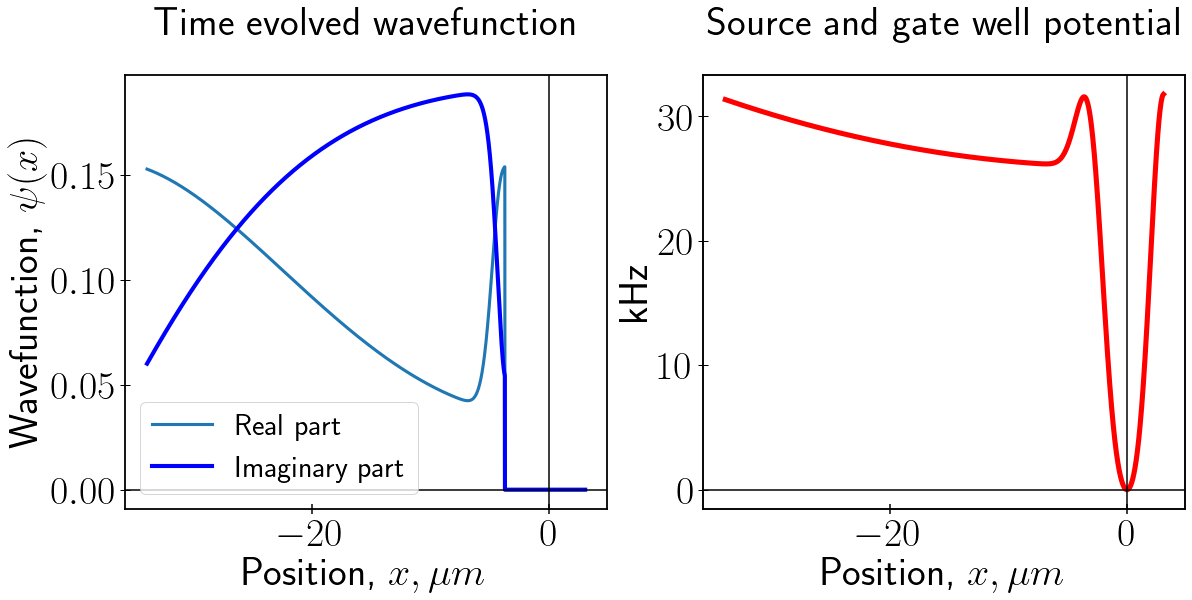

In [50]:
large = 40; med = 30; small = 20
params = {'axes.titlesize': large,
          'axes.titlepad' : large,
          'legend.fontsize': med,
          'axes.labelsize': large ,
          'axes.titlesize': large ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': large}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
plt.figure(1)

plt.subplot(121)
plt.plot(xs/(1.e-6),time_evolved_wavefunction.real,label="Real part",linewidth = 3.1)
plt.plot(xs/(1.e-6),time_evolved_wavefunction.imag,linewidth = 4.1,color='blue',label="Imaginary part")
plt.legend()
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.xticks(fontweight='bold')
plt.ylabel("Wavefunction, "+r"$\psi(x)$",fontweight='bold')  # Set Y-axis label
plt.yticks(fontweight='bold')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
plt.title('Time evolved wavefunction')
#plt.grid(linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.8)
    
plt.subplot(122)
# Plots the gate well potential.
#plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
#plt.ylabel(r"kHz")

# Plots the harmonic oscillator potential.
#plt.scatter(xs/(1.e-6),0.5*M*OMEGA**2*(xs)**2/(10**3*2*PI*H_BAR),s = 5,label="Harmonic potential")
plt.plot(xs/(1.e-6),source_and_gate_well_potential,color="red",linewidth = 5.1,label="")
#plt.legend()
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.ylabel(r"kHz")

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('Source and gate well potential')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
f.set_figwidth(19)
f.set_figheight(8)
for spine in ax.spines.values():
    spine.set_linewidth(1.9)
plt.show()